# ground-truth spike로 AE train data 꾸리기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
import torch

# os.chdir("./../data/")
my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
            "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
            "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
            "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
            "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
            "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
            "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]


dataset_num = 16
training_num = 2400
spike_length = 50

spike_train = [] # 스파이크 데이터를 저장할 배열
spike_test = [] # 스파이크 데이터를 저장할 배열

for ds in range(dataset_num):
    print("\ndata:", filename[ds])
    mat1 = io.loadmat(my_path_ground_BH + filename[ds])
    raw = mat1['data'][0]
    ans_times = mat1['spike_times'][0][0][0]
    ans_cluster = mat1['spike_class'][0][0][0]

    spike_this_dataset = []
    labal_this_dataset = []

    # raw 데이터의 기울기 계산
    slope = np.diff(raw) # raw보다 한 사이즈 작음.

    spike_group = np.zeros((len(ans_times), spike_length))

    train_spike_count = 0
    for i in range(len(ans_times)):
        max_slope_index = ans_times[i] + np.argmax(slope[ans_times[i] : ans_times[i] + 25])
        now_spike = raw[max_slope_index - 10 : max_slope_index - 10 + spike_length]
        spike_this_dataset.append(now_spike)
        labal_this_dataset.append(ans_cluster[i])
        if train_spike_count < training_num:
            train_spike_count += 1
            spike_train.append(now_spike)
        else:
            spike_test.append(now_spike)

    spike_this_dataset = np.array(spike_this_dataset)
    labal_this_dataset = np.array(labal_this_dataset)

    np.save(my_path_ground_BH + spike_tot[ds], spike_this_dataset)
    np.save(my_path_ground_BH + label_tot[ds], labal_this_dataset)

spike_train = np.array(spike_train)
spike_test = np.array(spike_test)
np.random.shuffle(spike_train)
np.random.shuffle(spike_test)

torch.save(torch.tensor(spike_train, dtype=torch.float32), my_path_ground_BH + 'BH_quiroga_training_dataset_gt_detect.pt')
torch.save(torch.tensor(spike_test, dtype=torch.float32), my_path_ground_BH + 'BH_quiroga_test_dataset_gt_detect.pt')


data: C_Easy1_noise005.mat

data: C_Easy1_noise01.mat

data: C_Easy1_noise015.mat

data: C_Easy1_noise02.mat

data: C_Easy2_noise005.mat

data: C_Easy2_noise01.mat

data: C_Easy2_noise015.mat

data: C_Easy2_noise02.mat

data: C_Difficult1_noise005.mat

data: C_Difficult1_noise01.mat

data: C_Difficult1_noise015.mat

data: C_Difficult1_noise02.mat

data: C_Difficult2_noise005.mat

data: C_Difficult2_noise01.mat

data: C_Difficult2_noise015.mat

data: C_Difficult2_noise02.mat


# detected spike로 AE train data와 acc 측정을 위한 스파이크 꾸리기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os

# os.chdir("./../data/")
my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'

filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])

dataset_num = 16
training_num = 2400
spike_length = 50
wait_term = 20

spike_train = [] # 스파이크 데이터를 저장할 배열
spike_test = [] # 스파이크 데이터를 저장할 배열

for ds in range(dataset_num):
    print("\ndata:", filename[ds])
    past_tr_num = len(spike_train)
    past_te_num = len(spike_test)
    train_spike_count = 0

    # 데이터 파일 불러오기
    mat1 = io.loadmat(my_path_ground_BH + filename[ds])
    raw = mat1['data'][0]
    
    # raw 데이터의 기울기 계산
    slope = np.diff(raw) # raw보다 한 사이즈 작음.
    
    # 스파이크 탐지
    wait = -20  # 스파이크 탐지 대기 시간 초기화: 처음에는 20샘플은 버림.
    for i in range(len(raw)-2):
        wait += 1
        if(wait_term < wait):
            if(raw[i+1] < raw[i+2] and raw[i+1] <= raw[i] and raw[i+1] < -thr) or (raw[i+1] > raw[i+2] and raw[i] <= raw[i+1] and raw[i+1] > thr):
                max_slope_index = i + np.argmax(slope[i - 8 : i + 5]) - 8 # 기울기가 최대인 지점에서 스파이크 추출
                if train_spike_count < training_num:
                    train_spike_count += 1
                    spike_train.append(raw[max_slope_index - 10 : max_slope_index - 10 + spike_length]) 
                else:
                    spike_test.append(raw[max_slope_index - 10 : max_slope_index - 10 + spike_length])
                wait = 0  # 대기 시간 초기화 # 다시 wait_term만큼 기다려라

                # if train_spike_count == 1: # 그림으로 보기
                #     plt.plot(raw[max_slope_index - 10 : max_slope_index + 40])
                    
                #     plt.title(f"align, max_slope_index={max_slope_index}")
                #     plt.xticks(range(50), labels=range(50))  # x축 눈금 설정
                #     plt.yticks(np.arange(min(raw[max_slope_index - 10 : max_slope_index + 40]), 
                #                         max(raw[max_slope_index - 10 : max_slope_index + 40]) + 1, 
                #                         step=1))  # y축 눈금 설정, step=1로 매 x마다 보이게 함
                    
                #     plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # 그래프에 그리드 추가
                #     plt.show()
    print("spike_train_size", len(spike_train)-past_tr_num)
    print("spike_test_size", len(spike_test)-past_te_num)
    print("spike_total", len(spike_train)-past_tr_num+len(spike_test)-past_te_num)
spike_train = np.array(spike_train)
spike_test = np.array(spike_test)
np.random.shuffle(spike_train)
np.random.shuffle(spike_test)

torch.save(torch.tensor(spike_train, dtype=torch.float32), my_path_ground_BH + 'BH_quiroga_training_dataset_real_detect.pt')
torch.save(torch.tensor(spike_test, dtype=torch.float32), my_path_ground_BH + 'BH_quiroga_test_dataset_real_detect.pt')



data: C_Easy1_noise005.mat
spike_train_size 2400
spike_test_size 1101
spike_total 3501

data: C_Easy1_noise01.mat
spike_train_size 2400
spike_test_size 1532
spike_total 3932

data: C_Easy1_noise015.mat
spike_train_size 2400
spike_test_size 1709
spike_total 4109

data: C_Easy1_noise02.mat
spike_train_size 2400
spike_test_size 1602
spike_total 4002

data: C_Easy2_noise005.mat
spike_train_size 2400
spike_test_size 893
spike_total 3293

data: C_Easy2_noise01.mat
spike_train_size 2400
spike_test_size 1014
spike_total 3414

data: C_Easy2_noise015.mat
spike_train_size 2400
spike_test_size 1026
spike_total 3426

data: C_Easy2_noise02.mat
spike_train_size 2400
spike_test_size 1065
spike_total 3465

data: C_Difficult1_noise005.mat
spike_train_size 2400
spike_test_size 897
spike_total 3297

data: C_Difficult1_noise01.mat
spike_train_size 2400
spike_test_size 1012
spike_total 3412

data: C_Difficult1_noise015.mat
spike_train_size 2400
spike_test_size 1190
spike_total 3590

data: C_Difficult1_nois

# 논문대로 템플릿 만들기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from scipy import io

my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'

# 데이터 파일 목록과 템플릿 파일 목록 설정
filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
             "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
             "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
             "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

thr_tem = np.array([0.9, 0.9, 0.9, 0.9,   1.0, 1.0, 1.0, 1.0,   0.7, 0.7, 0.7, 0.9,   0.9, 0.9, 0.9, 0.9])
thr_new_cluster = np.array([50, 50, 50, 50,   50, 50, 50, 50,   50, 30, 30, 50,   50, 50, 50, 50])
thr_merge_cluster = np.array([110, 110, 110, 110,   110, 110, 110, 110,   110, 110, 110, 110,   110, 110, 110, 110])
wait_term = np.array([20, 20, 20, 20,   20, 20, 20, 20,   20, 20, 20, 20,   20, 20, 20, 20])

# thr_tot = np.array([0.5, 0.5, 0.55, 0.7,  0.5, 0.5, 0.55, 0.7,  0.5, 0.5, 0.55, 0.7,  0.5, 0.5, 0.55, 0.7])

dataset_num = 16
spike_needs = 100 # 템플릿을 만들기 위해 필요한 스파이크 수
spike_length = 50
num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
cluster_delete_thr = 9 # spike_needs/10 # 이 숫자 초과인 클러스터만 생존

for ds in range(dataset_num):
    print("\ndata:", filename[ds])

    # 데이터 파일 불러오기
    mat1 = io.loadmat(my_path_ground_BH + filename[ds])
    raw = mat1['data'][0]
    thr = thr_tem[ds]  # 스파이크 탐지 임계값 설정 
    spike = []  # 스파이크 데이터를 저장할 배열

    # raw 데이터의 기울기 계산
    slope = np.diff(raw) # raw보다 한 사이즈 작음.
    
    # 스파이크 탐지
    wait = -20  # 스파이크 탐지 대기 시간 초기화: 처음에는 20샘플은 버림.
    spike_count = 0
    for i in range(len(raw)-2):
        wait += 1
        if(wait_term[ds] < wait):
            if(raw[i+1] < raw[i+2] and raw[i+1] <= raw[i] and raw[i+1] < -thr) or (raw[i+1] > raw[i+2] and raw[i] <= raw[i+1] and raw[i+1] > thr):
                spike_count += 1
                max_slope_index = i + np.argmax(slope[i - 8 : i + 5]) - 8 # 기울기가 최대인 지점에서 스파이크 추출
                spike.append(raw[max_slope_index - 10 : max_slope_index - 10 + spike_length]) 
                wait = 0  # 대기 시간 초기화 # 다시 wait_term[ds]만큼 기다려라
                if spike_count == spike_needs:
                    break
    spike = np.array(spike)

    Cluster = np.zeros((num_cluster, spike_length))  # 클러스터 배열 초기화
    cluster_num = np.zeros(num_cluster)  # 각 클러스터의 데이터 수 초기화
    
    sm_distance = np.zeros(num_cluster)
    mm_distance = np.zeros((num_cluster, num_cluster))

    # 훈련 사이클 시작
    current_cluster_num = 0
    for spike_index in range(spike_needs):
        spike_n = spike[spike_index, :]  # 현재 스파이크
        
        if(spike_index == 0):
            Cluster[0, :] = spike_n  # 첫 번째 스파이크는 첫 번째 클러스터에 배정
            cluster_num[0] = 1  # 클러스터 데이터 수 증가
            current_cluster_num += 1
        else:
            # 각 클러스터와의 거리 계산

            sm_smallest = 1000000000000
            sm_smallest_index = 0
            for i in range(num_cluster): # 0, 1, 2 까지는 기존 클러스터와 지금 스파이크와의 거리
                if cluster_num[i] > 0:
                    sm_distance[i] = np.sum(abs(Cluster[i, 5:25] - spike_n[5:25])) * 17 + np.sum(abs(Cluster[i, 0:5] - spike_n[0:5])) * 2 + np.sum(abs(Cluster[i, 25:50] - spike_n[25:50])) * 2
                    if sm_smallest > sm_distance[i]:
                        sm_smallest = sm_distance[i]
                        sm_smallest_index = i

            mm_smallest = 1000000000000
            mm_smallest_index_i = 0
            mm_smallest_index_j = 0
            for i in range(num_cluster):
                for j in range(i+1, num_cluster):
                    if cluster_num[i] > 0 and cluster_num[j] > 0:
                        mer_thr = 1.5 if spike_index < 30 else 2.5
                        mm_distance[i, j] = np.sum(abs(Cluster[i, 5:25] - Cluster[j, 5:25])) * 17 + np.sum(abs(Cluster[i, 0:5] - Cluster[j, 0:5])) * 2 + np.sum(abs(Cluster[i, 25:50] - Cluster[j, 25:50])) * 2            
                        mm_distance[i, j] = mm_distance[i, j] * mer_thr
                        if mm_smallest > mm_distance[i, j]:
                            mm_smallest = mm_distance[i, j]
                            mm_smallest_index_i = i
                            mm_smallest_index_j = j

            if current_cluster_num < num_cluster:
                # print('sm_smallest', sm_smallest)
                if sm_smallest > thr_new_cluster[ds]:
                    Cluster[current_cluster_num, :] = spike_n
                    cluster_num[current_cluster_num] = 1
                    current_cluster_num += 1
                else:
                    Cluster[sm_smallest_index, :] = (Cluster[sm_smallest_index, :] * 15 + spike_n) / 16
                    cluster_num[sm_smallest_index] += 1
            
            else:
                if sm_smallest < mm_smallest:
                    Cluster[sm_smallest_index, :] = (Cluster[sm_smallest_index, :] * 15 + spike_n) / 16
                    cluster_num[sm_smallest_index] += 1
                else: #merge
                    Cluster[mm_smallest_index_i, :] = (Cluster[mm_smallest_index_i, :] + Cluster[mm_smallest_index_j, :]) / 2
                    cluster_num[mm_smallest_index_i] += cluster_num[mm_smallest_index_j]
                    Cluster[mm_smallest_index_j, :] = spike_n
                    cluster_num[mm_smallest_index_j] = 1

    # print('before delete under 11', cluster_num)
    # cluster_num이 11이하면 해당 클러스터 없애기
    Cluster_temp = np.zeros((num_cluster, spike_length))  # 클러스터 배열 초기화
    cluster_num_temp = np.zeros(num_cluster)  # 각 클러스터의 데이터 수 초기화
    final_index = 0
    for i in range(num_cluster):
        if cluster_num[i] > cluster_delete_thr:
            Cluster_temp[final_index, :] = Cluster[i, :]
            cluster_num_temp[final_index] = cluster_num[i]
            final_index += 1
    current_cluster_num = final_index
    # print(cluster_num_temp)
    Cluster = Cluster_temp
    cluster_num = cluster_num_temp


    # 
    no_more_merge = False
    while (no_more_merge == False):
        no_more_merge = True
        final_mm_merge_index_i = 0
        final_mm_merge_index_j = 0
        for i in range(current_cluster_num):
            for j in range(i+1, current_cluster_num):
                if cluster_num[i] > 0 and cluster_num[j] > 0:
                    mer_thr = 2.5
                    final_mm_distance = np.sum(abs(Cluster[i, 5:25] - Cluster[j, 5:25])) * 17 + np.sum(abs(Cluster[i, 0:5] - Cluster[j, 0:5])) * 2 + np.sum(abs(Cluster[i, 25:50] - Cluster[j, 25:50])) * 2            
                    # print('final_mm_distance', final_mm_distance)
                    # print(cluster_num)
                    final_mm_distance = final_mm_distance * mer_thr
                    if final_mm_distance < thr_merge_cluster[ds]:
                        final_mm_merge_index_i = i
                        final_mm_merge_index_j = j
                        no_more_merge = False
                        break
            if no_more_merge == False:
                break
        
        if no_more_merge == False:
            Cluster[final_mm_merge_index_i, :] = (Cluster[final_mm_merge_index_i, :] + Cluster[final_mm_merge_index_j, :]) / 2
            cluster_num[final_mm_merge_index_i] += cluster_num[final_mm_merge_index_j]
            cluster_num[final_mm_merge_index_j] = 0
            current_cluster_num -= 1

            
            # 앞으로 다시 땡기기
            Cluster_temp = np.zeros((num_cluster, spike_length))  # 클러스터 배열 초기화
            cluster_num_temp = np.zeros(num_cluster)  # 각 클러스터의 데이터 수 초기화
            final_index = 0
            for i in range(num_cluster):
                if cluster_num[i] > cluster_delete_thr:
                    Cluster_temp[final_index, :] = Cluster[i, :]
                    cluster_num_temp[final_index] = cluster_num[i]
                    final_index += 1
            current_cluster_num = final_index
            Cluster = Cluster_temp
            cluster_num = cluster_num_temp



    # # Cluster plot
    # plt.figure(figsize=(12, 6))
    # colors = ['b', 'g', 'r', 'k']  # 클러스터별 색상 지정
    # x_axis = np.arange(spike_length)  # x축 값 (스파이크 길이)
    # # print(cluster_num)
    # for i in range(num_cluster):
    #     plt.plot(x_axis, Cluster[i, :], label=f'Cluster {i+1}', color=colors[i % len(colors)])

    # plt.title(f'Cluster Templates for {filename[ds]}, nums{cluster_num}')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Amplitude')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    
    # 클러스터 템플릿을 파일로 저장
    np.save(my_path_ground_BH + template[ds], Cluster)
        



data: C_Easy1_noise005.mat

data: C_Easy1_noise01.mat

data: C_Easy1_noise015.mat

data: C_Easy1_noise02.mat

data: C_Easy2_noise005.mat

data: C_Easy2_noise01.mat

data: C_Easy2_noise015.mat

data: C_Easy2_noise02.mat

data: C_Difficult1_noise005.mat

data: C_Difficult1_noise01.mat

data: C_Difficult1_noise015.mat

data: C_Difficult1_noise02.mat

data: C_Difficult2_noise005.mat

data: C_Difficult2_noise01.mat

data: C_Difficult2_noise015.mat

data: C_Difficult2_noise02.mat


# ssp.train.py

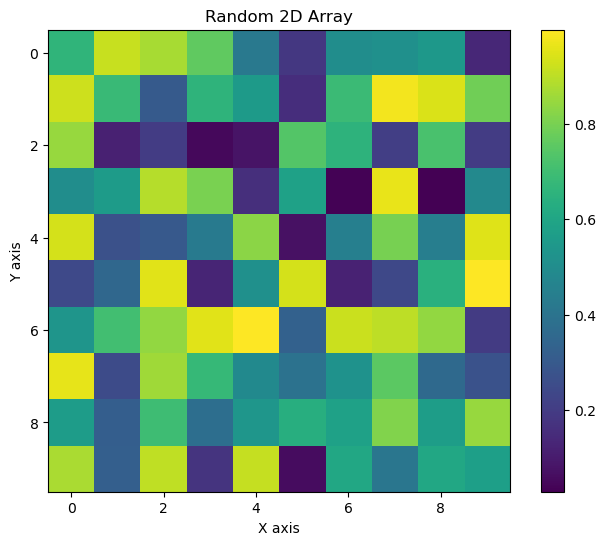

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime

# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
            "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
            "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
            "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
            "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
            "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
            "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
             "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
             "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
             "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'



# thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])

Conv_net = True
SAE_net = True

# hyperparameter
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
dataset_num = 16
spike_length = 50
n_sample = spike_length
num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
training_cycle = 2400 # 그 초기 몇개까지만 cluster update할지
AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect


batch_size = 32
max_epoch = 7000
learning_rate = 0.001
normalize_on = False # True or False # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
need_bias = False
# first_layer_no_train = False
lif_add_at_first = False
TIME = 10 # SAE일 때만 유효
my_seed = 42


seed_assign(my_seed)






class spikedataset(Dataset):
    def __init__(self, path, transform = None):    
        self.transform = transform
        self.spike = torch.load(path)
        
    def __getitem__(self, index):
        spike = self.spike[index]            
        if self.transform is not None:
            spike = self.transform(spike)
        return spike
    
    def __len__(self):
        return len(self.spike)

train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)


class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()

        # encoder
        self.conv1 = nn.Conv1d(1, 32, 3, stride = 2, bias = False) # 24
        self.conv2 = nn.Conv1d(32, 64, 3, stride = 2, bias = False) # 11
        self.conv3 = nn.Conv1d(64, 96, 3, stride = 2, bias = False) # 4 # 병현: 여기 5인데?
        self.fc1 = nn.Linear(96 * 5, 4, bias = False)
        
        # decoder
        self.fc4 = nn.Linear(4, 5 * 96, bias = False)
        self.deconv3 = nn.ConvTranspose1d(96, 64, 3, stride = 2, bias = False) #6 + 2 + 1= 9
        self.deconv1 = nn.ConvTranspose1d(64, 32, 3, stride = 2, output_padding=1, bias = False) #16(9-1)*stride + 4(kernel-1) + 1 = 21
        self.deconv2 = nn.ConvTranspose1d(32, 1, 3, stride = 2, output_padding=1, bias = False) #40 + 4 + 1 = 45

    def forward(self, x):

        # encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 96 * 5)
        mid = self.fc1(x)
        norm = torch.sqrt(torch.sum(torch.pow(mid, 2), dim = 1))
        h = (mid.t()/(norm + 1e-12)).t()

        # decoder
        z = F.relu(self.fc4(h))
        z = z.view(-1, 96, 5)
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv1(z))
        z = self.deconv2(z)

        return h, z
    


# net = AE()
# net = torch.nn.DataParallel(net)
    
# net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20241231_120818.pth')

# 모델 초기화
if SAE_net == False:
    if Conv_net == True:
        net = Autoencoder_conv1(input_channels=1, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias)
        net = torch.nn.DataParallel(net)
    else:
        net = Autoencoder_only_FC(encoder_ch=[96, 64, 32, 4], decoder_ch=[32,64,96,n_sample], n_sample=n_sample, need_bias=need_bias)
        net = torch.nn.DataParallel(net)
else:
    if Conv_net == True: 
        net = SAE_conv1(input_channels=1, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, 
                            synapse_fc_trace_const1=1, 
                            synapse_fc_trace_const2=0.5, #안씀 
                            TIME=TIME, v_init=0.0, v_decay=0.5, v_threshold=0.75, v_reset=10000.0, 
                            sg_width=4.0, surrogate='sigmoid', BPTT_on=True, need_bias=need_bias, lif_add_at_first=lif_add_at_first)
        net = torch.nn.DataParallel(net)
    else:
        net = SAE_fc_only(encoder_ch=[96, 64, 32, 4], 
                            decoder_ch=[32,64,96,n_sample], 
                            in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                            synapse_fc_trace_const1=1,
                            synapse_fc_trace_const2=0.5,  #안씀 
                            TIME=TIME, v_init=0.0, v_decay=0.5, v_threshold=0.75, v_reset=10000.0, 
                            sg_width=4.0, surrogate='sigmoid', BPTT_on=True, need_bias=need_bias, lif_add_at_first=lif_add_at_first)
        net = torch.nn.DataParallel(net)

In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


net = net.to(device)
print(net)
print('Device:',device)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

loss_history = []
mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
mean_cluster_accuracy_total_all_dataset_history = []

tau = np.zeros(num_cluster)

current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
print(f"\nStart Training, current_time = {current_time}")
best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0
for epoch in range(max_epoch):
    cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
    cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
    cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    
    
    if(epoch % 50 == 0): 
        print(f'\nepoch-{epoch} accuracy check')
        for ds in range(dataset_num):
            # print('\n', spike_tot[ds])

            spike_template = np.load(my_path_ground_BH + template[ds])
            spike = np.load(my_path_ground_BH + spike_tot[ds])
            label = np.load(my_path_ground_BH + label_tot[ds])
            
            Cluster = np.zeros((num_cluster, 4))
            assert Cluster.shape[-1] == 4, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
            
            net.eval()
            with torch.no_grad():
                for i in range(num_cluster):
                    spike_torch = torch.from_numpy(spike_template[i, :])
                    spike_torch = spike_torch.float().to(device)
                    if 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                    else:
                        spike_torch = spike_torch.unsqueeze(0)
                    inner_inf = net.module.encoder(spike_torch)
                    # print(inner_inf)
                    if 'SAE' in net.module.__class__.__name__:
                        inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                    Cluster[i, :] = inner_inf.cpu().detach().numpy()

            spike_hidden = np.zeros((len(spike), 4))
            net.eval()
            with torch.no_grad():
                for i in range(len(spike)):
                    spike_torch = torch.from_numpy(spike[i, :])
                    spike_torch = spike_torch.float().to(device)
                    if 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                    else:
                        spike_torch = spike_torch.unsqueeze(0)
                    inner_inf = net.module.encoder(spike_torch)
                    if 'SAE' in net.module.__class__.__name__:
                        inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                    spike_hidden[i, :] = inner_inf.cpu().detach().numpy()
                
            spike_id = np.zeros(len(spike))


            distance_sm = np.zeros(num_cluster)
            tau = np.zeros(num_cluster)
            
            for spike_index in range(len(spike)): 
                for q in range(num_cluster):
                    tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                # tau = np.dot(Cluster, spike_hidden[spike_index, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.

                for i in range(num_cluster): # l2 distance
                    distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))

                m = np.argmin(distance_sm)
                spike_id[spike_index] = m + 1
                if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                    Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16
                            
            # spike id 분포 확인하기
            # unique_elements, counts = np.unique(spike_id, return_counts=True)
            # print("Unique elements:", unique_elements)
            # print("Counts:", counts)

            cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
            cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
            cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
            
            label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
            label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
            perm_i = 0
            for perm in label_converter_permutations:
                label_converter = list(perm)
                # print(label_converter)
                correct_during_training_cycle = 0
                correct_post_training_cycle = 0

                assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                for i in range(len(spike_id)):
                    if(label_converter[int(spike_id[i]-1)] == label[i]):
                        if i < training_cycle:
                            correct_during_training_cycle += 1
                        else:
                            correct_post_training_cycle += 1

                cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                perm_i += 1

            cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
            cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
            cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]

        print('cluster_accuracy_post_training_cycle_all_dataset', cluster_accuracy_post_training_cycle_all_dataset)

        mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
        mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
        mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
        
        mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
        mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
        mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
        print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.2f}%")

        if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
            torch.save(net, f"net_save/save_now_net_{current_time}.pth")
            print('save model')
            best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset

    running_loss = 0.0
    net.train()
    for data in train_loader:
        optimizer.zero_grad()
        spike = data
        spike = spike.to(device)
        if 'SAE' in net.module.__class__.__name__:
            spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
        spike_class = net(spike)

        # if 'SAE' in net.module.__class__.__name__:
        #     spike = spike.mean(dim=1)# Time 방향으로 평균
        #     spike_class = spike_class.mean(dim=1)# Time 방향으로 평균

        if 'SAE' in net.module.__class__.__name__:
            loss1 = criterion(spike_class[:, :, 5:25], spike[:, :, 5:25])
            loss2 = criterion(spike_class[:, :, 0:5], spike[:, :, 0:5])
            loss3 = criterion(spike_class[:, :, 25:spike_length], spike[:, :, 25:spike_length])
        else:
            loss1 = criterion(spike_class[:, 5:25], spike[:, 5:25])
            loss2 = criterion(spike_class[:, 0:5], spike[:, 0:5])
            loss3 = criterion(spike_class[:, 25:spike_length], spike[:, 25:spike_length])

        loss = loss1 * 2.125 + (loss2 + loss3)/4
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    loss_history.append((epoch, avg_loss))
    print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')

DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for_one_two_coupling()
      (11): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (12): SSBH_DimChanger_for_one_two_decoupling()
      (13): LIF_layer()
      (14): SSBH_DimChanger_for_one_two_coupling()
      (15): SSBH_DimChanger_for_fc()
      (16): Linear(in_features=480, out_features=4, bias=False)
      (17): SSBH_L2NormLayer()
      (18): SSBH_DimChanger_for_one_two_decoupling()
      (19): SSBH_DimChanger_one_two

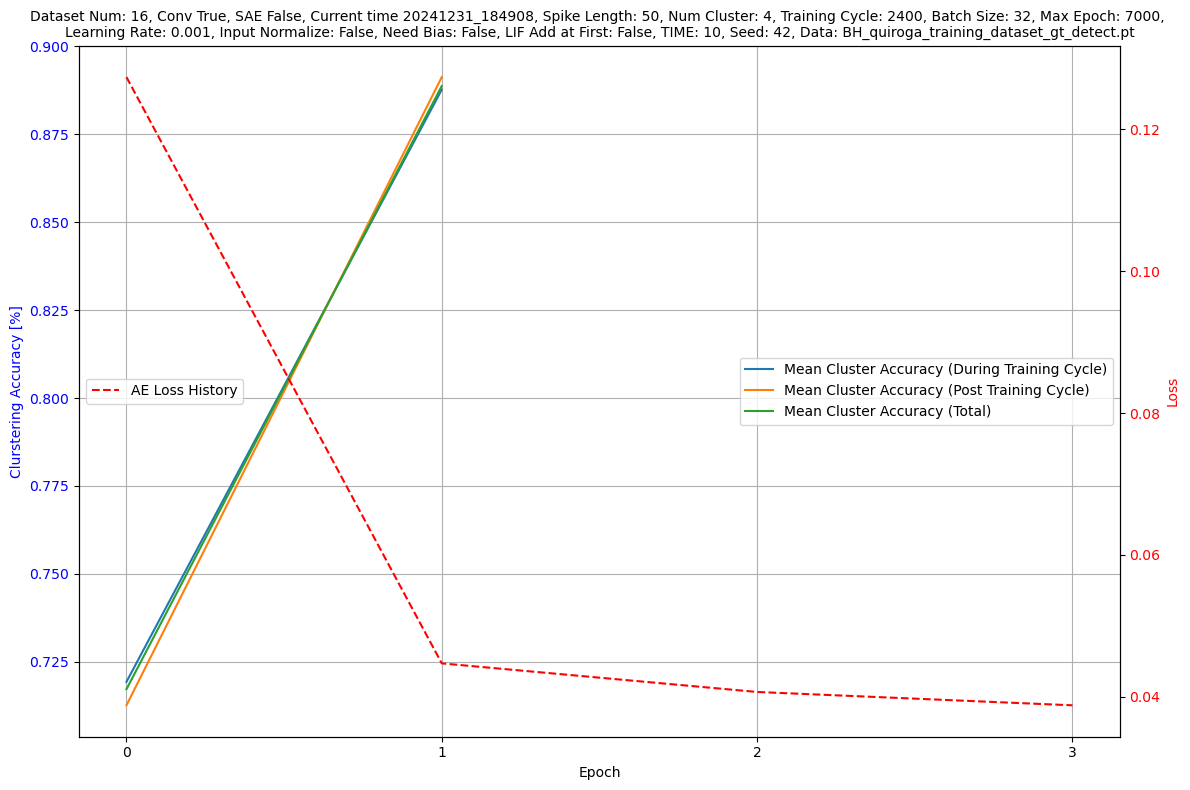

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 설정 정보 제목 작성
title = (
    f"Dataset Num: {dataset_num}, Conv {Conv_net}, SAE {SAE_net}, Current time {current_time}, Spike Length: {spike_length}, Num Cluster: {num_cluster}, "
    f"Training Cycle: {training_cycle}, Batch Size: {batch_size}, Max Epoch: {max_epoch}, \n"
    f"Learning Rate: {learning_rate}, Input Normalize: {normalize_on}, Need Bias: {need_bias}, "
    f"LIF Add at First: {lif_add_at_first}, TIME: {TIME}, Seed: {my_seed}, Data: {AE_train_data}"
)

# 데이터 리스트와 라벨 설정 (Loss 제외)
data_list = [
    ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
]

# 플롯 생성
fig, ax1 = plt.subplots(figsize=(12, 8))

# 첫 번째 y축: Accuracy 관련 데이터
for label, data in data_list:
    epochs, values = zip(*data)  # epoch, value 분리
    ax1.plot(epochs, values, label=label)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="center right")
ax1.grid(True)

# x축을 정수만 표시하도록 설정
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# 두 번째 y축: Loss History
ax2 = ax1.twinx()
epochs, values = zip(*loss_history)
ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
ax2.set_ylabel("Loss", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="center left")

# 제목 추가
plt.title(title, fontsize=10)
plt.tight_layout()
plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
plt.show()


# acc_metric.py

In [ ]:
import numpy as np

def acc_det(spike_index, spike_times, ans_times):
        k = 0
        FN = 0
        TP = 0
        FP = 0
        spike_true_index = np.zeros(10000)
        spike_false_index = np.zeros(10000)
        ans_index = np.zeros(10000)
        spike_times[spike_times == 0] = 1500000
        det_win = 20

        '''
        f = open('./../result/TP_index.txt', 'w')
        g = open('./../result/FP_index.txt', 'w')
        h = open('./../result/FN_index.txt', 'w')
        '''
        for j in range(len(ans_times)):
                if(ans_times[j] + det_win >= spike_times[k] and spike_times[k] >= ans_times[j] - det_win):
                        spike_true_index[TP] = k
                        ans_index[TP] = j
                        #f.write('%7d %7d'%(ans_times[j], spike_times[k]) +"\n")
                        TP = TP + 1
                        k = k + 1
                elif(ans_times[j] + det_win < spike_times[k]):
                        FN = FN + 1
                        #h.write('%7d'%(ans_times[j]) +"\n")
                else:
                        while(1):
                                spike_false_index[FP] = k
                                FP = FP + 1
                                #g.write('%7d'%(spike_times[k]) + "\n")
                                k = k + 1
                                if(ans_times[j] - det_win <= spike_times[k]):
                                        break
                        if(ans_times[j] + det_win >= spike_times[k]):
                                spike_true_index[TP] = k
                                ans_index[TP] = j
                                #f.write('%7d %7d'%(ans_times[j], spike_times[k]) +"\n")
                                TP = TP + 1
                                k = k + 1
                        else:
                                FN = FN + 1
				#h.write('%7d'%(ans_times[j]) +"\n")
        print("# of ans : ", len(ans_times))
        print("# of TP ; ", TP)
        print("# of FP ; ", FP)
        print("# of FN : ", FN)
        print("Det acc : ", TP/len(ans_times))
        return spike_true_index, spike_false_index, ans_index, TP, TP/len(ans_times)
''''
def acc_clu(numspike, spike_id, TP, spike_true_index, ans_index, ans_cluster):
	cluster_accuracy = np.zeros(6)
	for ep in range(6):
		if(ep == 1 or ep == 4):
			for i in range(numspike):
				if(spike_id[i] == 3):
					spike_id[i] = 2
				elif(spike_id[i] == 2):
					spike_id[i] = 3
		elif(ep == 2 or ep == 5):
			for i in range(numspike):
				if(spike_id[i] == 1):
					spike_id[i] = 2
				elif(spike_id[i] == 2):
					spike_id[i] = 1
		elif(ep == 3):
			for i in range(numspike):
				if(spike_id[i] == 1):
					spike_id[i] = 3
				elif(spike_id[i] == 3):
					spike_id[i] = 1
		true_cluster = 0
		for i in range(TP):
			if(spike_true_index[i] == 0) and (spike_true_index[i+1] == 0):
				print("break")
				break
			else:
				if(spike_id[int(spike_true_index[i])] == ans_cluster[int(ans_index[i])]):
					true_cluster += 1
		cluster_accuracy[ep] = true_cluster*100/TP
	print('Clu acc : ', max(cluster_accuracy))
	return max(cluster_accuracy)
'''

def acc(spike_index, spike_times, ans_times, spike_id, ans_cluster, training = 0):
        k = 0
        FN = 0
        TP = 0
        FP = 0
        spike_times[spike_times == 0] = 1500000
        det_win = 20
        id_ssp = np.zeros(10000)
        id_ans = np.zeros(10000)
        id_false = np.zeros(10000)
        training_TP = 0
        training_ans = 0
        training_cycle = 100
        for j in range(len(ans_times)):
                if(ans_times[j] + det_win >= spike_times[k] and spike_times[k] >= ans_times[j] - det_win):
                        id_ssp[TP] = spike_id[k]
                        id_ans[TP] = ans_cluster[j]		
                        TP = TP + 1
                        k = k + 1
                        if(k == training_cycle and training == 1):
                                training_TP = TP
                                training_ans = j
                elif(ans_times[j] + det_win < spike_times[k]):
                        FN = FN + 1
                else:
                        while(1):
                                id_false[FP] = spike_id[k]
                                FP = FP + 1

                                k = k + 1
                                if(k == training_cycle and training == 1):
                                        training_TP = TP
                                        training_ans = j

                                if(ans_times[j] - det_win <= spike_times[k]):
                                        break
                        if(ans_times[j] + det_win >= spike_times[k]):
                                id_ssp[TP] = spike_id[k]
                                id_ans[TP] = ans_cluster[j]
                                TP = TP + 1
                                k = k + 1
                                if(k == training_cycle and training == 1):
                                        training_TP = TP
                                        training_ans = j
                        else:
                                FN = FN + 1
        #print(training_TP, training_ans)
        print("# of ans : ", len(ans_times))
        print("# of TP ; ", TP)
        print('training miss : ', training_TP)
        print('# of Error : ', len(ans_times)-(TP-training_TP))
        
        #print("# of FP ; ", FP)
        print("# of FN : ", FN)
        print("Det acc : ", (TP-training_TP)/(len(ans_times)-training_ans))

        filtered_spike = 0
        filtered_noise = 0
        cluster_accuracy = np.zeros(6)
        true_clusters = np.zeros(6)
        noise = 0
        for i in range(TP):
                if(id_ssp[i] == 4):
                        filtered_spike += 1
        for i in range(FP):
                if(id_false[i] == 4):
                        filtered_noise += 1
        for ep in range(6):
                if(ep == 1 or ep == 4):
                        for i in range(spike_index):
                                if(id_ssp[i] == 3):
                                        id_ssp[i] = 2
                                elif(id_ssp[i] == 2):
                                        id_ssp[i] = 3
                elif(ep == 2 or ep == 5):
                        for i in range(spike_index):
                                if(id_ssp[i] == 1):
                                        id_ssp[i] = 2
                                elif(id_ssp[i] == 2):
                                        id_ssp[i] = 1
                elif(ep == 3):
                        for i in range(spike_index):
                                if(id_ssp[i] == 1):
                                        id_ssp[i] = 3
                                elif(id_ssp[i] == 3):
                                        id_ssp[i] = 1
                true_cluster = 0
                for i in range(training_TP, TP):
                        if(id_ssp[i] == id_ans[i]):
                                true_cluster += 1
                
                cluster_accuracy[ep] = true_cluster*100/(TP-filtered_spike-training_TP)
                true_clusters[ep] = true_cluster
        #print('filtered noise : ', filtered_noise)
        print('filtered spike : ', filtered_spike)
        print("true cluster : ", max(true_clusters))
        print('filtered FP : ', FP-filtered_noise)
        print('Final det acc : ', (TP-filtered_spike-training_TP)/(len(ans_times)-training_ans))

        print('Clu acc : ', max(cluster_accuracy))
	
        return (TP-training_TP-filtered_spike)/(len(ans_times)-training_ans), max(cluster_accuracy), max(true_clusters)



# (DEPRECATED) naive 템플릿 만들기. 이것도 라벨 필요 X

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import math
# import os
# from scipy import io

# my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'

# # 데이터 파일 목록과 템플릿 파일 목록 설정
# filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
#             "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
#             "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
#             "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

# template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
#              "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
#              "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
#              "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

# thr_tem = np.array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

# dataset_num = 16
# spike_needs = 100 # 템플릿을 만들기 위해 필요한 스파이크 수
# spike_length = 50
# wait_term = 20
# num_cluster = 3  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네

# for ds in range(dataset_num):
#     print("\ndata:", filename[ds])
#     spike_count = 0

#     # 데이터 파일 불러오기
#     mat1 = io.loadmat(my_path_ground_BH + filename[ds])
#     raw = mat1['data'][0]
#     thr = thr_tem[ds]  # 스파이크 탐지 임계값 설정 
#     spike = []  # 스파이크 데이터를 저장할 배열

#     # raw 데이터의 기울기 계산
#     slope = np.diff(raw) # raw보다 한 사이즈 작음.
    
#     # 스파이크 탐지
#     wait = -20  # 스파이크 탐지 대기 시간 초기화: 처음에는 20샘플은 버림.
#     for i in range(len(raw)-2):
#         wait += 1
#         if(wait_term < wait):
#             if(raw[i+1] < raw[i+2] and raw[i+1] <= raw[i] and raw[i+1] < -thr) or (raw[i+1] > raw[i+2] and raw[i] <= raw[i+1] and raw[i+1] > thr):
#                 spike_count += 1
#                 max_slope_index = i + np.argmax(slope[i - 8 : i + 5]) - 8 # 기울기가 최대인 지점에서 스파이크 추출
#                 spike.append(raw[max_slope_index - 10 : max_slope_index - 10 + spike_length]) 
#                 wait = 0  # 대기 시간 초기화 # 다시 wait_term만큼 기다려라
#                 if spike_count == spike_needs:
#                     break
#     spike = np.array(spike)

#     Cluster = np.zeros((num_cluster, spike_length))  # 클러스터 배열 초기화
#     distance_size = 0  # 거리 계산을 위한 배열 크기
#     cluster_num = np.zeros(num_cluster)  # 각 클러스터의 데이터 수 초기화
    
#     for i in range(num_cluster):
#         distance_size += i + 1  # 거리 계산 배열 크기 계산
#     distance = np.zeros(distance_size)  # 거리 배열 초기화 # num_cluster=3이면 1+2+3=6개의 거리를 계산해야 함.
    
#     # 훈련 사이클 시작
#     for spike_index in range(spike_needs):
#         spike_n = spike[spike_index, :]  # 현재 스파이크
        
#         if(spike_index == 0):
#             Cluster[0, :] = spike_n  # 첫 번째 스파이크는 첫 번째 클러스터에 배정
#             cluster_num[0] += 1  # 클러스터 데이터 수 증가
#         else:
#             # 각 클러스터와의 거리 계산
#             for i in range(num_cluster): # 0, 1, 2 까지는 기존 클러스터와 지금 스파이크와의 거리
#                 distance[i] = np.sum(abs(Cluster[i, 5:25] - spike_n[5:25])) * 17 + np.sum(abs(Cluster[i, 0:5] - spike_n[0:5])) * 2 + np.sum(abs(Cluster[i, 25:50] - spike_n[25:50])) * 2
            
#             k = 0
#             for j in range(1, num_cluster):
#                 k = k + j
#                 for i in range(j, num_cluster):
#                     # 훈련 초기 단계에서는 임계값을 1.5로 설정
#                     if(spike_index < 30):
#                         mer_thr = 1.5
#                     else:
#                         mer_thr = 2.5
                    
#                     # 클러스터의 데이터 수가 10 이상인 경우 거리를 크게 설정
#                     if(cluster_num[j-1] > 10) or (cluster_num[i] > 10):
#                         distance[i + j * num_cluster - k] = 1500000000000
#                     else:
#                         # 두 클러스터 간의 거리 계산
#                         distance[i + j * num_cluster - k] = np.sum(abs(Cluster[j - 1, 5:25] - Cluster[i, 5:25])) * 17 + np.sum(abs(Cluster[j - 1, 0:5] - Cluster[i, 0:5])) * 2 + np.sum(abs(Cluster[j - 1, 25:50] - Cluster[i, 25:50])) * 2
#                         distance[i + j * num_cluster - k] = distance[i + j * num_cluster - k] * mer_thr
            
#             # 가장 작은 거리를 가진 클러스터를 찾고 업데이트
#             m = np.argmin(distance)
#             if(m < num_cluster): #클러스터와 현재 스파이크간 거리에서 젤 작은 게 있을 때
#                 Cluster[m, :] = (Cluster[m, :] * 15 + spike_n) / 16  # 클러스터 업데이트
#                 cluster_num[m] += 1  # 클러스터 데이터 수 증가
#             else:  #클러스터와 클러스터 간 거리에서 젤 작은 게 있을 때
#                 x = num_cluster
#                 for i in range(1, num_cluster):
#                     y = x + num_cluster - i
#                     if(x <= m and m < y):
#                         # 새로운 클러스터와 기존 클러스터를 결합
#                         Cluster[i - 1, :] = (Cluster[i - 1, :] + Cluster[m - x + i, :]) / 2
#                         cluster_num[i - 1] = cluster_num[i - 1] + cluster_num[m - x + i]
#                         Cluster[m - x + i, :] = spike_n  # 새로운 스파이크 할당
#                         cluster_num[m - x + i] = 1  # 새로운 클러스터 데이터 수 1로 초기화
#                     x = y
#     # # Cluster plot
#     # plt.figure(figsize=(12, 6))
#     # colors = ['b', 'g', 'r']  # 클러스터별 색상 지정
#     # x_axis = np.arange(spike_length)  # x축 값 (스파이크 길이)
#     # print(cluster_num)
#     # for i in range(num_cluster):
#     #     plt.plot(x_axis, Cluster[i, :], label=f'Cluster {i+1}', color=colors[i % len(colors)])

#     # plt.title(f'Cluster Templates for {filename[ds]}')
#     # plt.xlabel('Sample Index')
#     # plt.ylabel('Amplitude')
#     # plt.legend()
#     # plt.grid(True)
#     # plt.show()
    
#     # 클러스터 템플릿을 파일로 저장
#     np.save(my_path_ground_BH + template[ds], Cluster)
        
